# TKAN example and comparison with benchmarks

All test have been run on a RTX 4070 with an Core™ i7-6700K on vast.ai using this [jax docker image](https://hub.docker.com/r/bitnami/jax/)

tkan version: 0.4.1

In [13]:
!pip install pandas numpy matplotlib pyarrow scikit-learn tkan "jax[cuda12]"

INFO: pip is looking at multiple versions of jax[cuda12] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax[cuda12] to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/25.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/25.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/25.1 MB ? eta -:--:--
    --------------------------------------- 0.5/25.1 MB 390.1 kB/s eta 0:01:04
    --------------------------------------- 0.5/25.1 MB 390.1 kB/s eta 0:01:04
    --------------------------------------- 0.5/25

In [1]:
import os
BACKEND = 'torch' # You can use any backend here 
os.environ['KERAS_BACKEND'] = BACKEND

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader,Dataset
import torch
import torch.nn as nn
# 创建目录（如果不存在）
os.makedirs('model', exist_ok=True)

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Flatten, GRU

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from tkan import TKAN

import time

# keras.utils.set_random_seed(1) 

N_MAX_EPOCHS = 100
BATCH_SIZE = 128
early_stopping_callback = lambda : keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=10,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=6,
)
lr_callback = lambda : keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=5,
    mode="min",
    min_delta=0.00001,
    min_lr=0.000025,
    verbose=0,
)
callbacks = lambda : [early_stopping_callback(), lr_callback(), keras.callbacks.TerminateOnNaN()]


# Data

In [15]:
df = pd.read_parquet('/workspace/data.parquet')
df = df[(df.index >= pd.Timestamp('2020-01-01')) & (df.index < pd.Timestamp('2023-01-01'))]
assets = ['BTC', 'ETH', 'ADA', 'XMR', 'EOS', 'MATIC', 'TRX', 'FTM', 'BNB', 'XLM', 'ENJ', 'CHZ', 'BUSD', 'ATOM', 'LINK', 'ETC', 'XRP', 'BCH', 'LTC']
df = df[[c for c in df.columns if 'quote asset volume' in c and any(asset in c for asset in assets)]]
df.columns = [c.replace(' quote asset volume', '') for c in df.columns]
display(df)

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/data.parquet'

In [4]:
class MinMaxScaler:
    def __init__(self, feature_axis=None, minmax_range=(0, 1)):
        """
        Initialize the MinMaxScaler.
        Args:
        feature_axis (int, optional): The axis that represents the feature dimension if applicable.
                                      Use only for 3D data to specify which axis is the feature axis.
                                      Default is None, automatically managed based on data dimensions.
        """
        self.feature_axis = feature_axis
        self.min_ = None
        self.max_ = None
        self.scale_ = None
        self.minmax_range = minmax_range # Default range for scaling (min, max)

    def fit(self, X):
        """
        Fit the scaler to the data based on its dimensionality.
        Args:
        X (np.array): The data to fit the scaler on.
        """
        if X.ndim == 3 and self.feature_axis is not None:  # 3D data
            axis = tuple(i for i in range(X.ndim) if i != self.feature_axis)
            self.min_ = np.min(X, axis=axis)
            self.max_ = np.max(X, axis=axis)
        elif X.ndim == 2:  # 2D data
            self.min_ = np.min(X, axis=0)
            self.max_ = np.max(X, axis=0)
        elif X.ndim == 1:  # 1D data
            self.min_ = np.min(X)
            self.max_ = np.max(X)
        else:
            raise ValueError("Data must be 1D, 2D, or 3D.")

        self.scale_ = self.max_ - self.min_
        return self

    def transform(self, X):
        """
        Transform the data using the fitted scaler.
        Args:
        X (np.array): The data to transform.
        Returns:
        np.array: The scaled data.
        """
        X_scaled = (X - self.min_) / self.scale_
        X_scaled = X_scaled * (self.minmax_range[1] - self.minmax_range[0]) + self.minmax_range[0]
        return X_scaled

    def fit_transform(self, X):
        """
        Fit to data, then transform it.
        Args:
        X (np.array): The data to fit and transform.
        Returns:
        np.array: The scaled data.
        """
        return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
        """
        Inverse transform the scaled data to original data.
        Args:
        X_scaled (np.array): The scaled data to inverse transform.
        Returns:
        np.array: The original data scale.
        """
        X = (X_scaled - self.minmax_range[0]) / (self.minmax_range[1] - self.minmax_range[0])
        X = X * self.scale_ + self.min_
        return X

def generate_data(df, sequence_length, n_ahead = 1):
    #Case without known inputs
    scaler_df = df.copy().shift(n_ahead).rolling(24 * 14).median()
    tmp_df = df.copy() / scaler_df
    tmp_df = tmp_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    scaler_df = scaler_df.iloc[24 * 14 + n_ahead:].fillna(0.)
    def prepare_sequences(df, scaler_df, n_history, n_future):
        X, y, y_scaler = [], [], []
        num_features = df.shape[1]
        
        # Iterate through the DataFrame to create sequences
        for i in range(n_history, len(df) - n_future + 1):
            # Extract the sequence of past observations
            X.append(df.iloc[i - n_history:i].values)
            # Extract the future values of the first column
            y.append(df.iloc[i:i + n_future,0:1].values)
            y_scaler.append(scaler_df.iloc[i:i + n_future,0:1].values)
        
        X, y, y_scaler = np.array(X), np.array(y), np.array(y_scaler)
        return X, y, y_scaler
    
    # Prepare sequences
    X, y, y_scaler = prepare_sequences(tmp_df, scaler_df, sequence_length, n_ahead)
    
    # Split the dataset into training and testing sets
    train_test_separation = int(len(X) * 0.8)
    X_train_unscaled, X_test_unscaled = X[:train_test_separation], X[train_test_separation:]
    y_train_unscaled, y_test_unscaled = y[:train_test_separation], y[train_test_separation:]
    y_scaler_train, y_scaler_test = y_scaler[:train_test_separation], y_scaler[train_test_separation:]
    
    # Generate the data
    X_scaler = MinMaxScaler(feature_axis=2)
    X_train = X_scaler.fit_transform(X_train_unscaled)
    X_test = X_scaler.transform(X_test_unscaled)
    
    y_scaler = MinMaxScaler(feature_axis=2)
    y_train = y_scaler.fit_transform(y_train_unscaled)
    y_test = y_scaler.transform(y_test_unscaled)
    
    y_train = y_train.reshape(y_train.shape[0], -1) 
    y_test = y_test.reshape(y_test.shape[0], -1)
    return X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test



In [2]:
class BatterySOCDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.features[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

def getData(train_files, test_file, batch_size, sequence=10):
    # 读取训练集 CSV 文件
    train_data = pd.concat([pd.read_csv(file) for file in train_files], ignore_index=True)

    # 数据预处理
    train_data.drop('Profile', axis=1, inplace=True)
    close_max = train_data['SOC'].max()  # SOC的最大值
    close_min = train_data['SOC'].min()  # SOC的最小值

    # 提取特征和标签
    features = train_data.iloc[:, :3].values  # 所有列除了最后一列
    labels = train_data.iloc[:, -1].values  # 最后一列为 SOC 标签

    # 归一化特征
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)

    # 直接剪去不足的样本
    if len(features) < sequence:
        features = features[:0]  # 使特征为空
        labels = labels[:0]  # 使标签为空
    else:
        # 计算可以构造的样本数量
        num_samples = len(features) - sequence + 1

        # 构造训练集的特征和标签
        X = np.array([features[i:(i + sequence)] for i in range(num_samples)], dtype=np.float32)
        Y = np.array([labels[i + sequence - 1] for i in range(num_samples)], dtype=np.float32)

    # 划分训练集
    total_len = len(Y)
    trainx, trainy = X, Y  # 全部作为训练集

    # 读取测试集 CSV 文件
    test_data = pd.concat([pd.read_csv(file) for file in test_file], ignore_index=True)
    test_data.drop('Profile', axis=1, inplace=True)

    # 提取特征和标签
    test_features = test_data.iloc[:, :3].values  # 所有列除了最后一列
    test_labels = test_data.iloc[:, -1].values  # 最后一列为 SOC 标签

    # 归一化测试集特征（使用训练集的缩放器）
    test_features = scaler.transform(test_features)
    
    # 直接剪去不足的样本
    if len(test_features) < sequence:
        test_features = test_features[:0]  # 使特征为空
        test_labels = test_labels[:0]  # 使标签为空
    else:
        # 计算测试集可以构造的样本数量
        test_num_samples = len(test_features) - sequence + 1

        # 构造测试集的特征和标签
        test_X = np.array([test_features[i:(i + sequence)] for i in range(test_num_samples)], dtype=np.float32)
        test_Y = np.array([test_labels[i + sequence - 1] for i in range(test_num_samples)], dtype=np.float32)
    
    # 构建DataLoader，用于批次训练
    train_loader = DataLoader(dataset=BatterySOCDataset(trainx, trainy), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=BatterySOCDataset(test_X, test_Y), batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, close_max, close_min

In [31]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Reshape
from keras.layers import Input, Concatenate

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def train():
    # 创建lstm模型实例，并将其移动到指定的设备（CPU或GPU）
# model = Sequential([
#                     Input(shape=(2,3)),
#                     # 添加卷积层
#     Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'),  # (1, 16, new_length)
#     MaxPooling1D(pool_size=2),  # 池化 (1, 16, new_length//2)
    
#     Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),  # (1, 32, new_length//2)
#     MaxPooling1D(pool_size=2),  # 池化 (1, 32, new_length//4)

#     # 需要将卷积层输出的形状调整为LSTM可接受的形状
#     Reshape((-1, 32)),  # 这里需要根据实际输出形状调整
#                     TKAN(100, return_sequences=True),
      
#                     TKAN(100, sub_kan_output_dim = 50, sub_kan_input_dim = 50, return_sequences=False),
                    
#                     Dense(units=1, activation='linear')
#                 ])
# 假设 TKAN 已经定义并返回隐藏状态和细胞状态
model_input = Input(shape=(10, 3))

# 添加卷积层
# x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(model_input)  # (None, 10, 16)
# x = MaxPooling1D(pool_size=2)(x)  # (None, 5, 16)

# x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)  # (None, 5, 32)
# x = MaxPooling1D(pool_size=2)(x)  # (None, 2, 32)

# # 调整形状以适应 LSTM 输入
# x = Reshape((-1, 32))(x)  # 形状为 (None, 1, 32)

# 添加 TKAN 层，获取输出和状态
forward_tkan = TKAN(100, return_sequences=True)(model_input)
# 反向TKAN层
reverse_tkan = LSTM(100, return_sequences=True, go_backwards=True)(model_input)

# 合并正向和反向TKAN层的输出
merged = Concatenate(axis=-1)([forward_tkan, reverse_tkan])
lstm_output2= TKAN(100, sub_kan_output_dim=50, sub_kan_input_dim=50, return_sequences=False)(merged)
# lstm_output2= TKAN(100,  sub_kan_output_dim = 50, sub_kan_input_dim = 50,return_sequences=False)(forward_tkan)

# 最后输出层
output = Dense(units=1, activation='linear')(lstm_output2)

# 创建模型
model = Model(inputs=model_input, outputs=output)
model.to(device)
# 加载模型权重
checkpoint = torch.load('model/best_CTKANBITKAN0.pth', map_location=device)
model.load_state_dict(checkpoint['state_dict'])  # 使用 
criterion = nn.MSELoss()  # 定义损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam梯度下降  学习率=0.001

    # train_loader, test_loader,close_max,close_min = getData(args.corpusFile,args.batch_size ) # 获取预处理后的数据
train_files = ['F:/TKAN-main/data/10C/DST_10C.csv', 'F:/TKAN-main/data/10C/FUDS_10C.csv','F:/TKAN-main/data/25C/DST_25C.csv','F:/TKAN-main/data/25C/FUDS_25C.csv',
               'F:/TKAN-main/data/30C/DST_30C.csv','F:/TKAN-main/data/30C/FUDS_30C.csv','F:/TKAN-main/data/40C/DST_40C.csv'
                   ,'F:/TKAN-main/data/40C/FUDS_40C.csv','F:/TKAN-main/data/50C/DST_50C.csv','F:/TKAN-main/data/50C/FUDS_50C.csv']
# test_file = ['F:/TKAN-main/data/10C/US06_10C.csv','F:/TKAN-main/data/25C/US06_25C.csv','F:/TKAN-main/data/30C/US06_30C.csv',
#              'F:/TKAN-main/data/40C/US06_40C.csv','F:/TKAN-main/data/50C/US06_50C.csv']
test_file = ['F:/TKAN-main/data/10C/US06_10C.csv']
batch_size = 16
train_loader, test_loader, close_max, close_min = getData(train_files, test_file, batch_size)
    # 初始化列表用于记录每个epoch的总损失
epoch_losses = []
labels = []  # 用于保存所有的真实值
preds = []  # 用于保存所有的预测值
best_rmse = float('inf')  # 初始化最佳RMSE为无穷大
best_r2 = -float('inf')  # 初始化最佳R^2为负无穷大

    # 打开一个名为 'lstm_loss_log.txt' 的文本文件，用于记录每个epoch的损失值
with open('lstm_loss_log.txt', 'w') as f:
    for i in range(N_MAX_EPOCHS):  # 循环遍历每个epoch
        total_loss = 0  # 初始化当前epoch的总损失
        all_labels = []  # 存储当前 epoch 的真实值
        all_preds = []  # 存储当前 epoch 的预测值
        for idx, (data, label) in enumerate(train_loader):
                
                    # data1 = data.squeeze(1).cuda() # 删除data张量中的第一个维度，并将其移动到GPU
            # print(f'data shape before unsqueeze: {data.shape}')
            pred= model((data).cuda()) # 将data1封装成Variable并传入模型进行前向传播，得到预测值
            # print(f'pred shape : {pred.shape}')
                    # pred = pred[1, :, :]  # 这里取pred的第二个维度的数据作为最终预测结果
                    # print(pred.shape)
            label = label.unsqueeze(1).cuda()  # 将标签数据添加一个维度并移动到GPU
                    # print(f'label shape before unsqueeze: {label.shape}')
                
                    
            loss = criterion(pred, label) # 计算当前batch的损失值
            optimizer.zero_grad() # 清空优化器的梯度
            loss.backward()   # 反向传播，计算梯度
            optimizer.step() # 更新模型参数
            total_loss += loss.item()   # 累加当前batch的损失值到total_loss
            rmse = torch.sqrt(nn.MSELoss()(pred.cpu(), label.cpu()))  # 均方根误差
                # R2计算
            R2 = r2_score(pred.detach().cpu().numpy(), label.detach().cpu().numpy())


                # 保存预测值和真实值
            all_preds.append(pred.detach().cpu().numpy())
            all_labels.append(label.detach().cpu().numpy())

                # 转换为numpy数组并合并数据
        labels = np.concatenate(all_labels)
        preds = np.concatenate(all_preds)
            # 记录每个epoch的总损失
        epoch_losses.append(total_loss)
            # 在终端输出第多少轮和对应的loss
        print(f'Epoch {i+1}, Loss: {total_loss}')
        print(f'Epoch {i + 1}, rmse: {rmse}')
        print(f'Epoch {i + 1}, R2: {R2}')
            
            # 将损失写入文件
        f.write(f'Epoch {i+1}, Loss: {total_loss}\n')
        model.eval()  # 将模型设置为评估模式
        with torch.no_grad():  # 关闭梯度计算
            test_preds = []
            test_labels = []
            for data, label in test_loader:
                data, label = data.cuda(), label.cuda()
                label = label.unsqueeze(1).cuda()
                pred = model(data)
                test_preds.append(pred.cpu().numpy())
                test_labels.append(label.cpu().numpy())
            
            test_preds = np.concatenate(test_preds)
            test_labels = np.concatenate(test_labels)
            
            # 计算测试集上的RMSE和R^2
            test_rmse = np.sqrt(np.mean((test_preds - test_labels) ** 2))
            test_r2 = r2_score(test_labels, test_preds)
            
            print(f'Epoch {i + 1}, Test RMSE: {test_rmse}')
            print(f'Epoch {i + 1}, Test R^2: {test_r2}')
            
            # 保存最佳模型
            if test_rmse < best_rmse or test_r2 > best_r2:
                best_rmse = min(best_rmse, test_rmse)
                best_r2 = max(best_r2, test_r2)
                torch.save({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()},'model/best_CTKANBITKAN0.pth')
                print('New best model saved.')
        
        model.train()  # 将模型设置回训练模式
            
    #     if i % 10 == 0: # 每10个epoch保存一次模型
    #         torch.save({'state_dict': model.state_dict()}, 'model/CTKAN00ggb.pth') # 保存模型的状态字典到指定文件
    #         print('第%d epoch，保存模型' % i) # 打印当前epoch信息，表示模型已经保存



    # torch.save({'state_dict': model.state_dict()}, 'model/CTKAN00ggb.pth') # 在训练结束后，保存最终模型


C:\Users\24666\AppData\Local\Temp\ipykernel_10732\881550347.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model/best_CTKANBITKAN0.pth', map_l

KeyboardInterrupt: 

In [17]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Reshape
from keras.layers import Input, Concatenate
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Reshape, Concatenate
from keras.optimizers import Adam
import torch.optim as optim
import time

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 设置随机数种子
# def set_seed(seed_value):
#     random.seed(seed_value)
#     np.random.seed(seed_value)
#     torch.manual_seed(seed_value)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed_value)
#         torch.cuda.manual_seed_all(seed_value)

# 定义模型
def build_model(sub_kan_input_dim, sub_kan_output_dim, dropout):
    model_input = Input(shape=(10, 3))  # 输入序列长度为10，特征维度为3
    forward_tkan = TKAN(100, dropout=dropout,return_sequences=True)(model_input)  # 使用TKAN层
    lstm_output2 = TKAN(100, sub_kan_output_dim=sub_kan_output_dim, sub_kan_input_dim=sub_kan_input_dim,dropout=dropout,
                         return_sequences=False)(forward_tkan)  # LSTM层后接TKAN
    output = Dense(units=1, activation='linear')(lstm_output2)  # 输出层
    model = Model(inputs=model_input, outputs=output)

    return model.to(device)

class BatterySOCDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.features[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

# 数据加载和预处理
def getData(train_files, test_file, batch_size, sequence=10):
    train_data = pd.concat([pd.read_csv(file) for file in train_files], ignore_index=True)
    train_data.drop('Profile', axis=1, inplace=True)
    close_max = train_data['SOC'].max()  # SOC的最大值
    close_min = train_data['SOC'].min()  # SOC的最小值

    features = train_data.iloc[:, :3].values
    labels = train_data.iloc[:, -1].values

    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)

    if len(features) < sequence:
        features = features[:0]
        labels = labels[:0]
    else:
        num_samples = len(features) - sequence + 1
        X = np.array([features[i:(i + sequence)] for i in range(num_samples)], dtype=np.float32)
        Y = np.array([labels[i + sequence - 1] for i in range(num_samples)], dtype=np.float32)

    test_data = pd.concat([pd.read_csv(file) for file in test_file], ignore_index=True)
    test_data.drop('Profile', axis=1, inplace=True)

    test_features = test_data.iloc[:, :3].values
    test_labels = test_data.iloc[:, -1].values

    test_features = scaler.transform(test_features)

    if len(test_features) < sequence:
        test_features = test_features[:0]
        test_labels = test_labels[:0]
    else:
        test_num_samples = len(test_features) - sequence + 1
        test_X = np.array([test_features[i:(i + sequence)] for i in range(test_num_samples)], dtype=np.float32)
        test_Y = np.array([test_labels[i + sequence - 1] for i in range(test_num_samples)], dtype=np.float32)
    
    train_loader = DataLoader(dataset=BatterySOCDataset(X, Y), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=BatterySOCDataset(test_X, test_Y), batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, close_max, close_min

# WOA优化器
class WOA:
    def __init__(self, population_size, max_iter, lower_bound, upper_bound, model):
        self.population_size = population_size
        self.max_iter = max_iter
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.population = np.random.uniform(lower_bound, upper_bound, (population_size, 5))  # 四个参数：学习率、批量大小、dropout、sub_kan_input_dim、sub_kan_output_dim
        self.best_position = None
        self.best_score = float('inf')

    def gaussian_chaos_initialization(self):
        dim = len(self.lower_bound)  # 获取解空间的维度
        population = np.random.uniform(low=-1.0, high=1.0, size=(population_size, dim))
        # 高斯混沌变换
        a = 0.5  # 可调的参数
        r = np.random.random(population.shape)
        population = np.exp(-a * population**2) - r
        # 使用np.clip确保初始化后的位置在范围内
        population = np.clip(population, self.lower_bound, self.upper_bound)
        return population

    def nonlinear_weight_update(self, t):
        return 2 - 2 * t / self.max_iter

    def levy_flight(self, dim):
        u = np.random.normal(0, 1, dim)
        v = np.random.normal(0, 1, dim)
        step = u / np.abs(v)**(1/1.5)
        return step

    def elite_opposition_based_learning(self):
        elite_index = np.argmin(self.fitness(self.population))
        elite_solution = self.population[elite_index]
        opposite_solution = 2 * elite_solution - self.best_position
        return opposite_solution
    
    def fitness(self, position):
        start_time1 = time.time()  # 开始时间
        lr, batch_size,dropout,sub_kan_input_dim,sub_kan_output_dim = position[0], int(position[1]),position[2],int(position[3]),int(position[4])
        # 重新构建模型
        self.model = build_model(sub_kan_input_dim, sub_kan_output_dim, dropout).to(device)
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train_files = ['F:/TKAN-main/data/10C/DST_10C.csv', 'F:/TKAN-main/data/10C/FUDS_10C.csv','F:/TKAN-main/data/25C/DST_25C.csv','F:/TKAN-main/data/25C/FUDS_25C.csv',
               'F:/TKAN-main/data/30C/DST_30C.csv','F:/TKAN-main/data/30C/FUDS_30C.csv','F:/TKAN-main/data/40C/DST_40C.csv'
                   ,'F:/TKAN-main/data/40C/FUDS_40C.csv','F:/TKAN-main/data/50C/DST_50C.csv','F:/TKAN-main/data/50C/FUDS_50C.csv']
        test_file = ['F:/TKAN-main/data/10C/US06_10C.csv']
        train_loader, test_loader, close_max, close_min = getData(train_files, test_file, batch_size, sequence=sequence_length)
        end_time1 = time.time()  # 结束时间
        print(f'Total time dataset: {end_time1 - start_time1:.2f} seconds')
        
        # 训练模型
        start_time2 = time.time()  # 开始时间
        self.model.train()
        total_loss = 0
        for epoch in range(10):  # 训练10个epochs
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        
            # 计算测试集上的RMSE和R2
            self.model.eval()
            preds, labels = [], []
            with torch.no_grad():
                for inputs, batch_labels in test_loader:
                    inputs = inputs.to(device)
                    batch_labels = batch_labels.unsqueeze(1).cuda()
                    batch_labels = batch_labels.to(device)
                    batch_preds = self.model(inputs)
                    preds.append(batch_preds.cpu().numpy())
                    labels.append(batch_labels.cpu().numpy())
            preds = np.concatenate(preds)
            labels = np.concatenate(labels)
            rmse = np.sqrt(mean_squared_error(labels, preds))
            r2 = r2_score(labels, preds)
            self.model.train()
            # 打印RMSE和R2
            print(f'Epoch {epoch+1}, RMSE: {rmse}, R2: {r2},lr:{lr},batch:{batch_size},loss:{total_loss},dropout:{dropout}\nsub_kan_input_dim:{sub_kan_input_dim},sub_kan_output_dim:{sub_kan_output_dim}')
            end_time2 = time.time()  # 结束时间
            print(f'Total time train: {end_time2 - start_time2:.2f} seconds')
        # 返回均方误差作为适应度分数
        return total_loss / len(train_loader)

    def optimize(self):
        self.gaussian_chaos_initialization()
        for t in range(self.max_iter):
            a = self.nonlinear_weight_update(t)
            for i in range(self.population_size):
                score = self.fitness(self.population[i])
                if score < self.best_score:
                    self.best_score = score
                    self.best_position = self.population[i]
                    print(f"New best score found: {self.best_score} at position {self.best_position}")
                A = 2 * a * np.random.random() - a
                C = 2 * np.random.random()
                p = np.random.random()
                if p < 0.5:
                    if abs(C) > 1:
                        D = abs(np.random.uniform(-1, 2) * (self.best_position - self.population[i]))
                        X_new = self.population[i] - A * D
                    else:
                        D = abs(C * (self.best_position - self.population[i]))
                        X_new = self.population[i] - A * D
                else:
                    X_new = self.population[i] + A * (self.best_position - self.population[i])
                X_new = np.clip(X_new, self.lower_bound, self.upper_bound)
                self.population[i] = X_new
                if t > self.max_iter * 2 / 3:
                    opposite_solution = self.elite_opposition_based_learning()
                    self.population[i] = opposite_solution
        return self.best_position


# 使用示例：
train_files = ['F:/TKAN-main/data/10C/DST_10C.csv', 'F:/TKAN-main/data/10C/FUDS_10C.csv','F:/TKAN-main/data/25C/DST_25C.csv','F:/TKAN-main/data/25C/FUDS_25C.csv',
               'F:/TKAN-main/data/30C/DST_30C.csv','F:/TKAN-main/data/30C/FUDS_30C.csv','F:/TKAN-main/data/40C/DST_40C.csv'
                   ,'F:/TKAN-main/data/40C/FUDS_40C.csv','F:/TKAN-main/data/50C/DST_50C.csv','F:/TKAN-main/data/50C/FUDS_50C.csv']
test_file = ['F:/TKAN-main/data/10C/US06_10C.csv']

sequence_length = 10

population_size = 10
max_iter = 20
lower_bound = [0.00001, 16, 0.0, 10, 10]  # 学习率、批量大小、dropout、sub_kan_input_dim的下界
upper_bound = [0.001, 64, 0.5, 50 ,50]  # 学习率、批量大小、dropout、sub_kan_output_dim的上界
woa = WOA(population_size,  
          max_iter=max_iter, lower_bound=lower_bound, upper_bound=upper_bound, model=model)

best_position = woa.optimize()
print(f"Best position: {best_position}")

# 使用最佳参数重新训练模型
lr, batch_size,dropout,sub_kan_input_dim,sub_kan_output_dim = best_position[0], int(best_position[1]),best_position[2],int(best_position[3]),int(best_position[4])
train_loader, test_loader, close_max, close_min = getData(train_files, test_file, batch_size, sequence=sequence_length)
model = build_model(sub_kan_input_dim, sub_kan_output_dim, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
best_rmse = float('inf')  # 初始化最佳RMSE为无穷大
best_r2 = -float('inf')  # 初始化最佳R^2为负无穷大
model.train()
print('最佳训练')
for epoch in range(1):  # 训练100个epochs
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        # 计算测试集上的RMSE和R2
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for inputs, batch_labels in test_loader:
            inputs = inputs.to(device)
            batch_labels = batch_labels.unsqueeze(1).cuda()
            batch_labels = batch_labels.to(device)
            batch_preds = model(inputs)
            preds.append(batch_preds.cpu().numpy())
            labels.append(batch_labels.cpu().numpy())
        preds = np.concatenate(preds)
        labels = np.concatenate(labels)
        rmse = np.sqrt(mean_squared_error(labels, preds))
        r2 = r2_score(labels, preds)
        model.train()       
        print(f'epoch {epoch}, Best Position: {best_position}, RMSE: {rmse}, R2: {r2},dropout:{dropout}\nsub_kan_input_dim:{sub_kan_input_dim},sub_kan_output_dim:{sub_kan_output_dim}')

            # 保存最佳模型
        if rmse < best_rmse or r2 > best_r2:
            best_rmse = min(best_rmse, rmse)
            best_r2 = max(best_r2, r2)
            torch.save({'state_dict': model.state_dict()},'model/best_model.pth')
            print('New best model saved.')


# # 保存最好的模型
# torch.save(model.state_dict(), 'best_model.pth')

Total time dataset: 0.13 seconds
Epoch 1, RMSE: 0.18152019381523132, R2: 0.602104127407074,lr:0.0004228517846555483,batch:50,loss:97.58694640360773,dropout:5.718740867244332e-05
sub_kan_input_dim:22,sub_kan_output_dim:15
Total time train: 114.85 seconds


KeyboardInterrupt: 

In [1]:
from matplotlib import font_manager
from keras.models import Sequential, Model

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
font_path = 'C:/Windows/Fonts/simsun.ttc'  # 示例：使用微软雅黑
font_prop = font_manager.FontProperties(fname=font_path)

# model = Sequential([
#                     Input(shape=(3,3)),
#                     # 添加卷积层
#     # Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'),  # (1, 16, new_length)
#     # MaxPooling1D(pool_size=2),  # 池化 (1, 16, new_length//2)
    
#     # Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),  # (1, 32, new_length//2)
#     # MaxPooling1D(pool_size=2),  # 池化 (1, 32, new_length//4)

#     # # 需要将卷积层输出的形状调整为LSTM可接受的形状
#     # Reshape((-1, 32)),  # 这里需要根据实际输出形状调整
#                     TKAN(100, return_sequences=True),
#                     TKAN(100, sub_kan_output_dim = 50, sub_kan_input_dim = 50, return_sequences=False),
#                     Dense(units=1, activation='linear')
#                 ])
model_input = Input(shape=(10, 3))

# 添加卷积层
# x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(model_input)  # (None, 10, 16)
# x = MaxPooling1D(pool_size=2)(x)  # (None, 5, 16)

# x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)  # (None, 5, 32)
# x = MaxPooling1D(pool_size=2)(x)  # (None, 2, 32)

# # 调整形状以适应 LSTM 输入
# x = Reshape((-1, 32))(x)  # 形状为 (None, 1, 32)

# 添加 TKAN 层，获取输出和状态
forward_tkan = TKAN(100, return_sequences=True)(model_input)
# 反向TKAN层
reverse_tkan = TKAN(100, return_sequences=True, go_backwards=True)(model_input)

# 合并正向和反向TKAN层的输出
merged = Concatenate(axis=-1)([forward_tkan, reverse_tkan])
lstm_output2= TKAN(100, sub_kan_output_dim=50, sub_kan_input_dim=50, return_sequences=False)(merged)

# 最后输出层
output = Dense(units=1, activation='linear')(lstm_output2)

# # 创建模型
model = Model(inputs=model_input, outputs=output)
model.to(device)  # 将模型移到指定的设备（CPU或GPU）
checkpoint = torch.load('model/best_CTKANBITKAN.pth', weights_only=True)  # 加载模型的状态字典
model.load_state_dict(checkpoint['state_dict']) # 将状态字典加载到模型中
preds = [] # 初始化预测值列表
labels = []  # 初始化真实标签值列表
total_loss = 0
criterion = nn.MSELoss()
    # train_loader, test_loader,close_max,close_min = getData(args.corpusFile, args.batch_size)  # 获取训练和测试数据
train_files = ['F:/TKAN-main/data/10C/DST_10C.csv', 'F:/TKAN-main/data/10C/FUDS_10C.csv','F:/TKAN-main/data/25C/DST_25C.csv','F:/TKAN-main/data/25C/FUDS_25C.csv',
               'F:/TKAN-main/data/30C/DST_30C.csv','F:/TKAN-main/data/30C/FUDS_30C.csv','F:/TKAN-main/data/40C/DST_40C.csv'
                   ,'F:/TKAN-main/data/40C/FUDS_40C.csv','F:/TKAN-main/data/50C/DST_50C.csv','F:/TKAN-main/data/50C/FUDS_50C.csv']
test_file = ['F:/TKAN-main/data/30C/US06_30C.csv']
batch_size = 16
train_loader, test_loader, close_max, close_min = getData(train_files, test_file, batch_size)
for idx, (data, label) in enumerate(test_loader):   # 遍历测试数据进行预测
    data = data.cuda()  # Move data to the specified device
    label = label.unsqueeze(1).cuda() # Add dimension and move to device
    pred = model(data)
    preds.append(pred.detach().cpu().numpy())
    labels.append(label.detach().cpu().numpy())

# data=pd.read_csv(r"data/10C/DST_10C.csv")
preds = np.concatenate(preds, axis=0)
labels = np.concatenate(labels, axis=0)
print(f"All predictions shape: {preds.shape}, All labels shape: {labels.shape}")

    # 计算评价指标
rmse = torch.sqrt(nn.MSELoss()(torch.tensor(preds), torch.tensor(labels)))  # 均方根误差
mae = torch.mean(torch.abs(torch.tensor(preds) - torch.tensor(labels)))  # 平均绝对误差
# Mmse=torch.sqrt(nn.MSELoss()(torch.tensor(train), torch.tensor(train.mean())))
r2=r2_score(preds, labels)

labels = np.array(labels)
preds = np.array(preds)

print(f"Labels shape: {labels.shape}, Predictions shape: {preds.shape}")
# print(train.shape)
# print(test.shape)
print(f'RMSE: {rmse.item():.6f}')
print(f'MAE: {mae.item():.6f}')
# print(f'Mmse: {Mmse.item():.6f}')
print(f'r^2: {r2:.6f}')

plt.figure(figsize=(10, 5))
plt.plot(labels, label='真实值', color='blue', linestyle='-')
plt.plot(preds, label='预测值', color='orange', linestyle='--')
plt.title('真实值与预测值随Epoch变化的直线图',fontproperties=font_prop)
plt.xlabel('NUM')
plt.ylabel('值',fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid()
plt.show()


ModuleNotFoundError: No module named 'tensorflow.compiler.tf2xla.python.xla'

All predictions shape: (6778, 1), All labels shape: (6778, 1)
Labels shape: (6778, 1), Predictions shape: (6778, 1)
RMSE: 0.036315
MAE: 0.025346
r^2: 0.984153


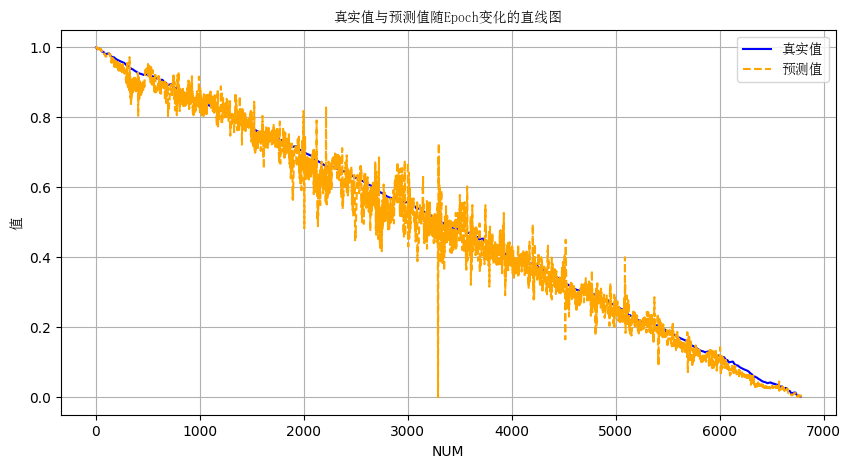

In [26]:
from matplotlib import font_manager
from keras.models import Sequential, Model

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
font_path = 'C:/Windows/Fonts/simsun.ttc'  # 示例：使用微软雅黑
font_prop = font_manager.FontProperties(fname=font_path)

# model = Sequential([
#                     Input(shape=(3,3)),
#                     # 添加卷积层
#     # Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'),  # (1, 16, new_length)
#     # MaxPooling1D(pool_size=2),  # 池化 (1, 16, new_length//2)
    
#     # Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),  # (1, 32, new_length//2)
#     # MaxPooling1D(pool_size=2),  # 池化 (1, 32, new_length//4)

#     # # 需要将卷积层输出的形状调整为LSTM可接受的形状
#     # Reshape((-1, 32)),  # 这里需要根据实际输出形状调整
#                     TKAN(100, return_sequences=True),
#                     TKAN(100, sub_kan_output_dim = 50, sub_kan_input_dim = 50, return_sequences=False),
#                     Dense(units=1, activation='linear')
#                 ])
model_input = Input(shape=(10, 3))

# 添加卷积层
# x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(model_input)  # (None, 10, 16)
# x = MaxPooling1D(pool_size=2)(x)  # (None, 5, 16)

# x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)  # (None, 5, 32)
# x = MaxPooling1D(pool_size=2)(x)  # (None, 2, 32)

# # 调整形状以适应 LSTM 输入
# x = Reshape((-1, 32))(x)  # 形状为 (None, 1, 32)

# 添加 TKAN 层，获取输出和状态
forward_tkan =TKAN(100, return_sequences=True)(model_input)
# 反向TKAN层
# reverse_tkan = LSTM(100, return_sequences=True, go_backwards=True)(model_input)

# # 合并正向和反向TKAN层的输出
# merged = Concatenate(axis=-1)([forward_tkan, reverse_tkan])
lstm_output2= TKAN(100, sub_kan_output_dim = 50, sub_kan_input_dim = 50, return_sequences=False)(forward_tkan)

# 最后输出层
output = Dense(units=1, activation='linear')(lstm_output2)

# # 创建模型
model = Model(inputs=model_input, outputs=output)
model.to(device)  # 将模型移到指定的设备（CPU或GPU）
checkpoint = torch.load('model/best_model.pth', weights_only=True)  # 加载模型的状态字典
model.load_state_dict(checkpoint['state_dict']) # 将状态字典加载到模型中
preds = [] # 初始化预测值列表
labels = []  # 初始化真实标签值列表
total_loss = 0
criterion = nn.MSELoss()
    # train_loader, test_loader,close_max,close_min = getData(args.corpusFile, args.batch_size)  # 获取训练和测试数据
train_files = ['F:/TKAN-main/data/10C/DST_10C.csv', 'F:/TKAN-main/data/10C/FUDS_10C.csv','F:/TKAN-main/data/25C/DST_25C.csv','F:/TKAN-main/data/25C/FUDS_25C.csv',
               'F:/TKAN-main/data/30C/DST_30C.csv','F:/TKAN-main/data/30C/FUDS_30C.csv','F:/TKAN-main/data/40C/DST_40C.csv'
                   ,'F:/TKAN-main/data/40C/FUDS_40C.csv','F:/TKAN-main/data/50C/DST_50C.csv','F:/TKAN-main/data/50C/FUDS_50C.csv']
# test_file = ['F:/TKAN-main/data/10C/US06_10C.csv','F:/TKAN-main/data/25C/US06_25C.csv','F:/TKAN-main/data/30C/US06_30C.csv',
#              'F:/TKAN-main/data/40C/US06_40C.csv','F:/TKAN-main/data/50C/US06_50C.csv']
test_file = ['F:/TKAN-main/data/10C/US06_10C.csv']
batch_size = 25
train_loader, test_loader, close_max, close_min = getData(train_files, test_file, batch_size)
for idx, (data, label) in enumerate(test_loader):   # 遍历测试数据进行预测
    data = data.cuda()  # Move data to the specified device
    label = label.unsqueeze(1).cuda() # Add dimension and move to device
    pred = model(data)
    preds.append(pred.detach().cpu().numpy())
    labels.append(label.detach().cpu().numpy())

# data=pd.read_csv(r"data/10C/DST_10C.csv")
preds = np.concatenate(preds, axis=0)
labels = np.concatenate(labels, axis=0)
print(f"All predictions shape: {preds.shape}, All labels shape: {labels.shape}")

    # 计算评价指标
rmse = torch.sqrt(nn.MSELoss()(torch.tensor(preds), torch.tensor(labels)))  # 均方根误差
mae = torch.mean(torch.abs(torch.tensor(preds) - torch.tensor(labels)))  # 平均绝对误差
# Mmse=torch.sqrt(nn.MSELoss()(torch.tensor(train), torch.tensor(train.mean())))
r2=r2_score(preds, labels)

labels = np.array(labels)
preds = np.array(preds)

print(f"Labels shape: {labels.shape}, Predictions shape: {preds.shape}")
# print(train.shape)
# print(test.shape)
print(f'RMSE: {rmse.item():.6f}')
print(f'MAE: {mae.item():.6f}')
# print(f'Mmse: {Mmse.item():.6f}')
print(f'r^2: {r2:.6f}')

plt.figure(figsize=(10, 5))
plt.plot(labels, label='真实值', color='blue', linestyle='-')
plt.plot(preds, label='预测值', color='orange', linestyle='--')
plt.title('真实值与预测值随Epoch变化的直线图',fontproperties=font_prop)
plt.xlabel('NUM')
plt.ylabel('值',fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid()
plt.show()

In [5]:
n_aheads = [1, 3, 6, 9, 12, 15]
models = [
    "TKAN",
    "GRU",
    "LSTM",
 ]

results = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}
results_rmse = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}
time_results = {model: {n_ahead: [] for n_ahead in n_aheads} for model in models}
for n_ahead in n_aheads:
    sequence_length = max(45, 5 * n_ahead)
    X_scaler, X_train, X_test, X_train_unscaled, X_test_unscaled, y_scaler, y_train, y_test, y_train_unscaled, y_test_unscaled, y_scaler_train, y_scaler_test = generate_data(df, sequence_length, n_ahead)
    
    for model_id in models:
        
        for run in range(10):

            if model_id == 'TKAN':
                model = Sequential([
                    Input(shape=X_train.shape[1:]),
                    TKAN(100, return_sequences=True),
                    TKAN(100, sub_kan_output_dim = 20, sub_kan_input_dim = 20, return_sequences=False),
                    Dense(units=n_ahead, activation='linear')
                ], name = model_id)
            elif model_id == 'GRU':
                model = Sequential([
                    Input(shape=X_train.shape[1:]),
                    GRU(100, return_sequences=True),
                    GRU(100, return_sequences=False),
                    Dense(units=n_ahead, activation='linear')
                ], name = model_id)
            elif model_id == 'LSTM':
                model = Sequential([
                    Input(shape=X_train.shape[1:]),
                    LSTM(100, return_sequences=True),
                    LSTM(100, return_sequences=False),
                    Dense(units=n_ahead, activation='linear')
                ], name = model_id)
            else:
                raise ValueError
            
            optimizer = keras.optimizers.Adam(0.001)
            model.compile(optimizer=optimizer, loss='mean_squared_error', jit_compile=True)
            if run==0:
                model.summary()
                
            # Fit the model
            start_time = time.time()
            history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_MAX_EPOCHS, validation_split=0.2, callbacks=callbacks(), shuffle=True, verbose = False)
            end_time = time.time()
            time_results[model_id][n_ahead].append(end_time - start_time)
            # Evaluate the model on the test set
            preds = model.predict(X_test, verbose=False)
            r2 = r2_score(y_true=y_test, y_pred=preds)
            print(end_time - start_time, r2)
            rmse = root_mean_squared_error(y_true=y_test, y_pred=preds)
            results[model_id][n_ahead].append(r2)
            results_rmse[model_id][n_ahead].append(rmse)
    
            del model
            del optimizer
                

print('R2 scores')
print('Means:')
display(pd.DataFrame({model_id: {n_ahead: np.mean(results[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results.keys()}))
display(pd.DataFrame({model_id: {n_ahead: np.mean(results_rmse[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_rmse.keys()}))
print('Std:')
display(pd.DataFrame({model_id: {n_ahead: np.std(results[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results.keys()}))
display(pd.DataFrame({model_id: {n_ahead: np.std(results_rmse[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in results_rmse.keys()}))
print('Training Times')
display(pd.DataFrame({model_id: {n_ahead: np.mean(time_results[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in time_results.keys()}))
display(pd.DataFrame({model_id: {n_ahead: np.std(time_results[model_id][n_ahead]) for n_ahead in n_aheads} for model_id in time_results.keys()}))

Model: "TKAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan (TKAN)                     │ (None, 45, 100)        │        41,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_1 (TKAN)                   │ (None, 100)            │        67,670 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,087 (426.12 KB)

 Trainable params: 109,067 (426.04 KB)

 Non-trainable params: 20 (80.00 B)

87.7924542427063 0.2883694212812108
58.81150460243225 0.2996397661396135
93.38526654243469 0.3341084410571994
69.46869540214539 0.31051983221133617
68.03620338439941 0.2921106524335578
69.86754989624023 0.31632189994316484
83.32379245758057 0.3110331089568017
87.04948496818542 0.32794331666897736
84.89363670349121 0.31305216100227273
65.98418259620667 0.30768323851050017


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 45, 100)        │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,001 (378.91 KB)

 Trainable params: 97,001 (378.91 KB)

 Non-trainable params: 0 (0.00 B)

25.800300121307373 0.39845659417931767
33.090811014175415 0.3765754299721896
29.157642126083374 0.3996904390926539
20.830080032348633 0.39383111789434266
24.594220638275146 0.39854787088819454
25.829734086990356 0.3980608345819734
20.8519549369812 0.39818872394114213
29.55962371826172 0.39876597794912183
28.695900917053223 0.4014753210019817
31.473294496536255 0.385033271890177


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 45, 100)        │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,501 (501.96 KB)

 Trainable params: 128,501 (501.96 KB)

 Non-trainable params: 0 (0.00 B)

17.663942098617554 0.3868841900601451
18.93087387084961 0.36429593525523807
17.406195163726807 0.3900695412878702
20.44808530807495 0.3786097961170115
16.755755186080933 0.392573888221295
20.213451862335205 0.3840845450430137
22.768882513046265 0.36630601832303555
18.173134088516235 0.3832138605836025
17.591335773468018 0.3918248620808171
19.007630586624146 0.37993474576853103


Model: "TKAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan_20 (TKAN)                  │ (None, 45, 100)        │        41,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_21 (TKAN)                  │ (None, 100)            │        67,670 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,289 (426.91 KB)

 Trainable params: 109,269 (426.83 KB)

 Non-trainable params: 20 (80.00 B)

96.62368559837341 0.2039716435474497
74.19592547416687 0.1932276162314687
79.30283999443054 0.186078923268888
67.78045701980591 0.1888747778655048
90.85375475883484 0.20038166436812602
83.50374150276184 0.198828800729096
79.80795526504517 0.1848691783440326
59.527796268463135 0.18538958325425756
73.05465388298035 0.17813436933288326
77.17678189277649 0.185736715040992


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_20 (GRU)                    │ (None, 45, 100)        │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,203 (379.70 KB)

 Trainable params: 97,203 (379.70 KB)

 Non-trainable params: 0 (0.00 B)

32.23410701751709 0.24445524304420677
34.76943516731262 0.2201955661466759
25.166553735733032 0.23882125234574236
28.084814310073853 0.2344194906558783
27.79819416999817 0.235279604982632
31.362367868423462 0.23122380522590277
24.73177719116211 0.2426694875126042
26.578373432159424 0.23963082071966313
27.062561988830566 0.24032075216240234
28.228745222091675 0.24178121308010916


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 45, 100)        │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,703 (502.75 KB)

 Trainable params: 128,703 (502.75 KB)

 Non-trainable params: 0 (0.00 B)

20.623400688171387 0.14482767971630928
21.055927991867065 0.07395821838488396
24.374985218048096 0.022805938949401933
21.713353157043457 0.0749404329796987
21.184755563735962 0.1522887184364525
18.015154600143433 0.16326070883053923
18.17797017097473 0.1804372350265144
17.993833541870117 0.18266789728362973
18.728025197982788 0.14342017896777437
20.97398853302002 -0.002893617498768264


Model: "TKAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan_40 (TKAN)                  │ (None, 45, 100)        │        41,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_41 (TKAN)                  │ (None, 100)            │        67,670 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,592 (428.09 KB)

 Trainable params: 109,572 (428.02 KB)

 Non-trainable params: 20 (80.00 B)

65.0717043876648 0.12467616278770983
90.68930077552795 0.13929252527937125
76.80289697647095 0.12103943728777532
84.18350672721863 0.13730972361175564
59.469563484191895 0.10800808332018592
80.92852973937988 0.13700481460829453
85.58175778388977 0.1324956475675861
78.75041937828064 0.13073665118121205
80.78611373901367 0.12963646594644282
73.53622269630432 0.12723135400013533


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_40 (GRU)                    │ (None, 45, 100)        │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_41 (GRU)                    │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,506 (380.88 KB)

 Trainable params: 97,506 (380.88 KB)

 Non-trainable params: 0 (0.00 B)

26.26027750968933 0.1602740337153421
30.87123155593872 0.12435047691678952
30.425692319869995 0.10110813722797496
29.073087215423584 0.13987663037711742
27.583446502685547 0.12691294524178082
30.0588481426239 0.09291668323995494
30.896180629730225 0.13374339087226397
26.069262266159058 0.13703060900398636
26.07837224006653 0.14521618469459105
28.18198537826538 0.13697203267595567


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 45, 100)        │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,006 (503.93 KB)

 Trainable params: 129,006 (503.93 KB)

 Non-trainable params: 0 (0.00 B)

25.56489086151123 0.07762226752057655
17.17194938659668 -0.030710740566574007
22.08793616294861 0.12124885788661292
18.8874089717865 -0.19992596769356452
18.460254669189453 -0.03568727060662086
19.47718334197998 -0.1732379052017987
18.813477754592896 -0.0515297041407121
18.96723985671997 -0.00603457861723435
17.978565216064453 0.06545331792210407
18.76132583618164 -0.21833925712011495


Model: "TKAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan_60 (TKAN)                  │ (None, 45, 100)        │        41,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_61 (TKAN)                  │ (None, 100)            │        67,670 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 9)              │           909 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,895 (429.28 KB)

 Trainable params: 109,875 (429.20 KB)

 Non-trainable params: 20 (80.00 B)

79.56117129325867 0.10413605110577702
95.19019293785095 0.10785571960353318
62.058950901031494 0.1022740221679086
57.313427448272705 0.09659038594513981
95.39828181266785 0.11798299575914914
109.50233817100525 0.11471786200051105
91.66243028640747 0.10141240448038549
83.4484133720398 0.11271609311366479
80.45564818382263 0.10729036960326731
89.72633719444275 0.10601871726343631


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_60 (GRU)                    │ (None, 45, 100)        │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_61 (GRU)                    │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 9)              │           909 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,809 (382.07 KB)

 Trainable params: 97,809 (382.07 KB)

 Non-trainable params: 0 (0.00 B)

22.387739181518555 0.12872665220206386
30.9358811378479 0.07007529147404491
30.65935730934143 0.06094348103987125
22.681428909301758 0.11531462257235203
30.2576744556427 -0.009184511914249627
23.401977062225342 0.1145808233763385
29.867743015289307 -0.0020916084892752293
21.44379758834839 0.13675731715603687
32.31744432449341 0.08318358609980472
36.52803301811218 -0.02434265870166709


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_60 (LSTM)                  │ (None, 45, 100)        │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 9)              │           909 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,309 (505.11 KB)

 Trainable params: 129,309 (505.11 KB)

 Non-trainable params: 0 (0.00 B)

20.542985439300537 -0.058979852588216475
19.61976170539856 -0.07973171479104875
19.607908487319946 -0.15736860736964103
17.53559136390686 -0.09773126198658748
19.434728860855103 -0.39964713298492527
20.465200901031494 -0.2428380152707189
18.985889673233032 -0.5012525957302113
20.644855260849 -0.2738693890416318
19.245380401611328 -0.05146921829097126
19.828939199447632 -0.0008553086817381464


Model: "TKAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan_80 (TKAN)                  │ (None, 60, 100)        │        41,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_81 (TKAN)                  │ (None, 100)            │        67,670 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 12)             │         1,212 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,198 (430.46 KB)

 Trainable params: 110,178 (430.38 KB)

 Non-trainable params: 20 (80.00 B)

102.03934359550476 0.0950019998069378
121.27882838249207 0.10264306639669311
108.56248140335083 0.0990784027938416
77.42332911491394 0.0915531316015012
108.50404167175293 0.09352464587821978
95.75039339065552 0.092634008105403
102.65606546401978 0.09820662504181471
130.8202440738678 0.09765221932195063
113.90040755271912 0.09989627016065132
118.27212023735046 0.1041245428645089


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_80 (GRU)                    │ (None, 60, 100)        │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_81 (GRU)                    │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 12)             │         1,212 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,112 (383.25 KB)

 Trainable params: 98,112 (383.25 KB)

 Non-trainable params: 0 (0.00 B)

35.47221755981445 0.04088546661722716
36.82418465614319 0.03298667710271531
29.090290307998657 0.08667586160493074
27.488890886306763 0.09733002632430683
30.277069330215454 0.10445165105456156
26.764411687850952 0.11400616888042837
35.36870241165161 0.02046360232907878
26.94648003578186 0.11067681945648022
35.716086864471436 0.02628936001538192
32.919156312942505 0.05842798641178421


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_80 (LSTM)                  │ (None, 60, 100)        │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_81 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 12)             │         1,212 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,612 (506.30 KB)

 Trainable params: 129,612 (506.30 KB)

 Non-trainable params: 0 (0.00 B)

26.069539546966553 -0.36695473176783655
21.807262659072876 -0.25014631415290206
20.902458667755127 -0.11645941888847307
22.4891197681427 -0.052407595508665694
22.018208742141724 -0.1754222997379895
23.925899028778076 -0.444045746274295
23.6626615524292 -0.2362643247514915
20.98034143447876 -0.16545529402468354
22.008980751037598 -0.23959377820038377
21.912462949752808 -0.5002557724294028


Model: "TKAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tkan_100 (TKAN)                 │ (None, 75, 100)        │        41,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_101 (TKAN)                 │ (None, 100)            │        67,670 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 15)             │         1,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,501 (431.64 KB)

 Trainable params: 110,481 (431.57 KB)

 Non-trainable params: 20 (80.00 B)

108.7913281917572 0.09994023646490877
156.19587421417236 0.08586536769033742
151.76872277259827 0.0953234353911566
109.25939583778381 0.08350316914250061
120.67966675758362 0.09383066359946372
118.93469595909119 0.09027677327433754
117.88046956062317 0.09486514143615367
106.22660422325134 0.09703190398065814
154.6233696937561 0.09741707472392
124.99523186683655 0.09227563879811171


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_100 (GRU)                   │ (None, 75, 100)        │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_101 (GRU)                   │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 15)             │         1,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,415 (384.43 KB)

 Trainable params: 98,415 (384.43 KB)

 Non-trainable params: 0 (0.00 B)

41.711098432540894 0.04633579312704695
37.61102104187012 0.041959092296909146
33.6794171333313 0.08124711803653464
41.39418888092041 0.062273110060791455
33.090798139572144 0.09644091868374302
34.905259132385254 0.0688485348099919
31.54578924179077 0.09070480771844083
31.649243354797363 0.08222696375881307
34.72465991973877 0.07408738048462013
34.364349365234375 0.06764429477726015


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_100 (LSTM)                 │ (None, 75, 100)        │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_101 (LSTM)                 │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 15)             │         1,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,915 (507.48 KB)

 Trainable params: 129,915 (507.48 KB)

 Non-trainable params: 0 (0.00 B)

27.019399642944336 -0.02014558059192651
24.994324684143066 -0.034652205897714984
29.875847578048706 -0.2883331388024311
27.68077278137207 -0.19307423134624493
32.10626721382141 -0.1967002645401843
26.022549629211426 -0.10374175022709843
28.117710828781128 -0.0705739546737177
30.498241662979126 -0.25929543857022325
24.907368898391724 -0.09258147039272031
26.723052978515625 -0.15915120445580425
R2 scores
Means:


,TKAN,GRU,LSTM
1,0.310078,0.394863,0.381780
3,0.190549,0.236880,0.113571
6,0.128743,0.129840,-0.045114
9,0.107099,0.067396,-0.186374
12,0.097431,0.069219,-0.254701
15,0.093033,0.071177,-0.141825


,TKAN,GRU,LSTM
1,0.058833,0.055101,0.055693
3,0.063659,0.061720,0.066402
6,0.066264,0.066109,0.072302
9,0.066893,0.068206,0.076763
12,0.067267,0.068214,0.079032
15,0.067711,0.068456,0.075833


Std:


,TKAN,GRU,LSTM
1,0.013617,0.007498,0.009371
3,0.007820,0.006761,0.063202
6,0.008831,0.018997,0.112792
9,0.006202,0.057011,0.156331
12,0.004002,0.035374,0.135507
15,0.004925,0.016791,0.087433


,TKAN,GRU,LSTM
1,0.000581,0.000340,0.000421
3,0.000316,0.000273,0.002282
6,0.000347,0.000707,0.003831
9,0.000237,0.002033,0.004908
12,0.000157,0.001278,0.004174
15,0.000187,0.000609,0.002844


Training Times


,TKAN,GRU,LSTM
1,76.861277,26.988356,18.895929
3,78.182759,28.601693,20.284139
6,77.580002,28.549838,19.617023
9,84.431719,28.048108,19.591124
12,107.920725,31.686749,22.577694
15,126.935536,35.467582,27.794554


,TKAN,GRU,LSTM
1,11.082262,3.945290,1.723379
3,10.159973,3.052013,1.950043
6,8.965218,1.885116,2.320250
9,14.904037,4.894200,0.870263
12,14.096107,3.808997,1.490844
15,18.705339,3.458216,2.267511
